# Generative Models
***

**Autumn 2025, MSc course**


## Assignment 3

***


*Authored by Arip Asadulaev & Manh Lab*

*Adapted by Rostislav Korst*

***


### Метрики качества генерации:

IS

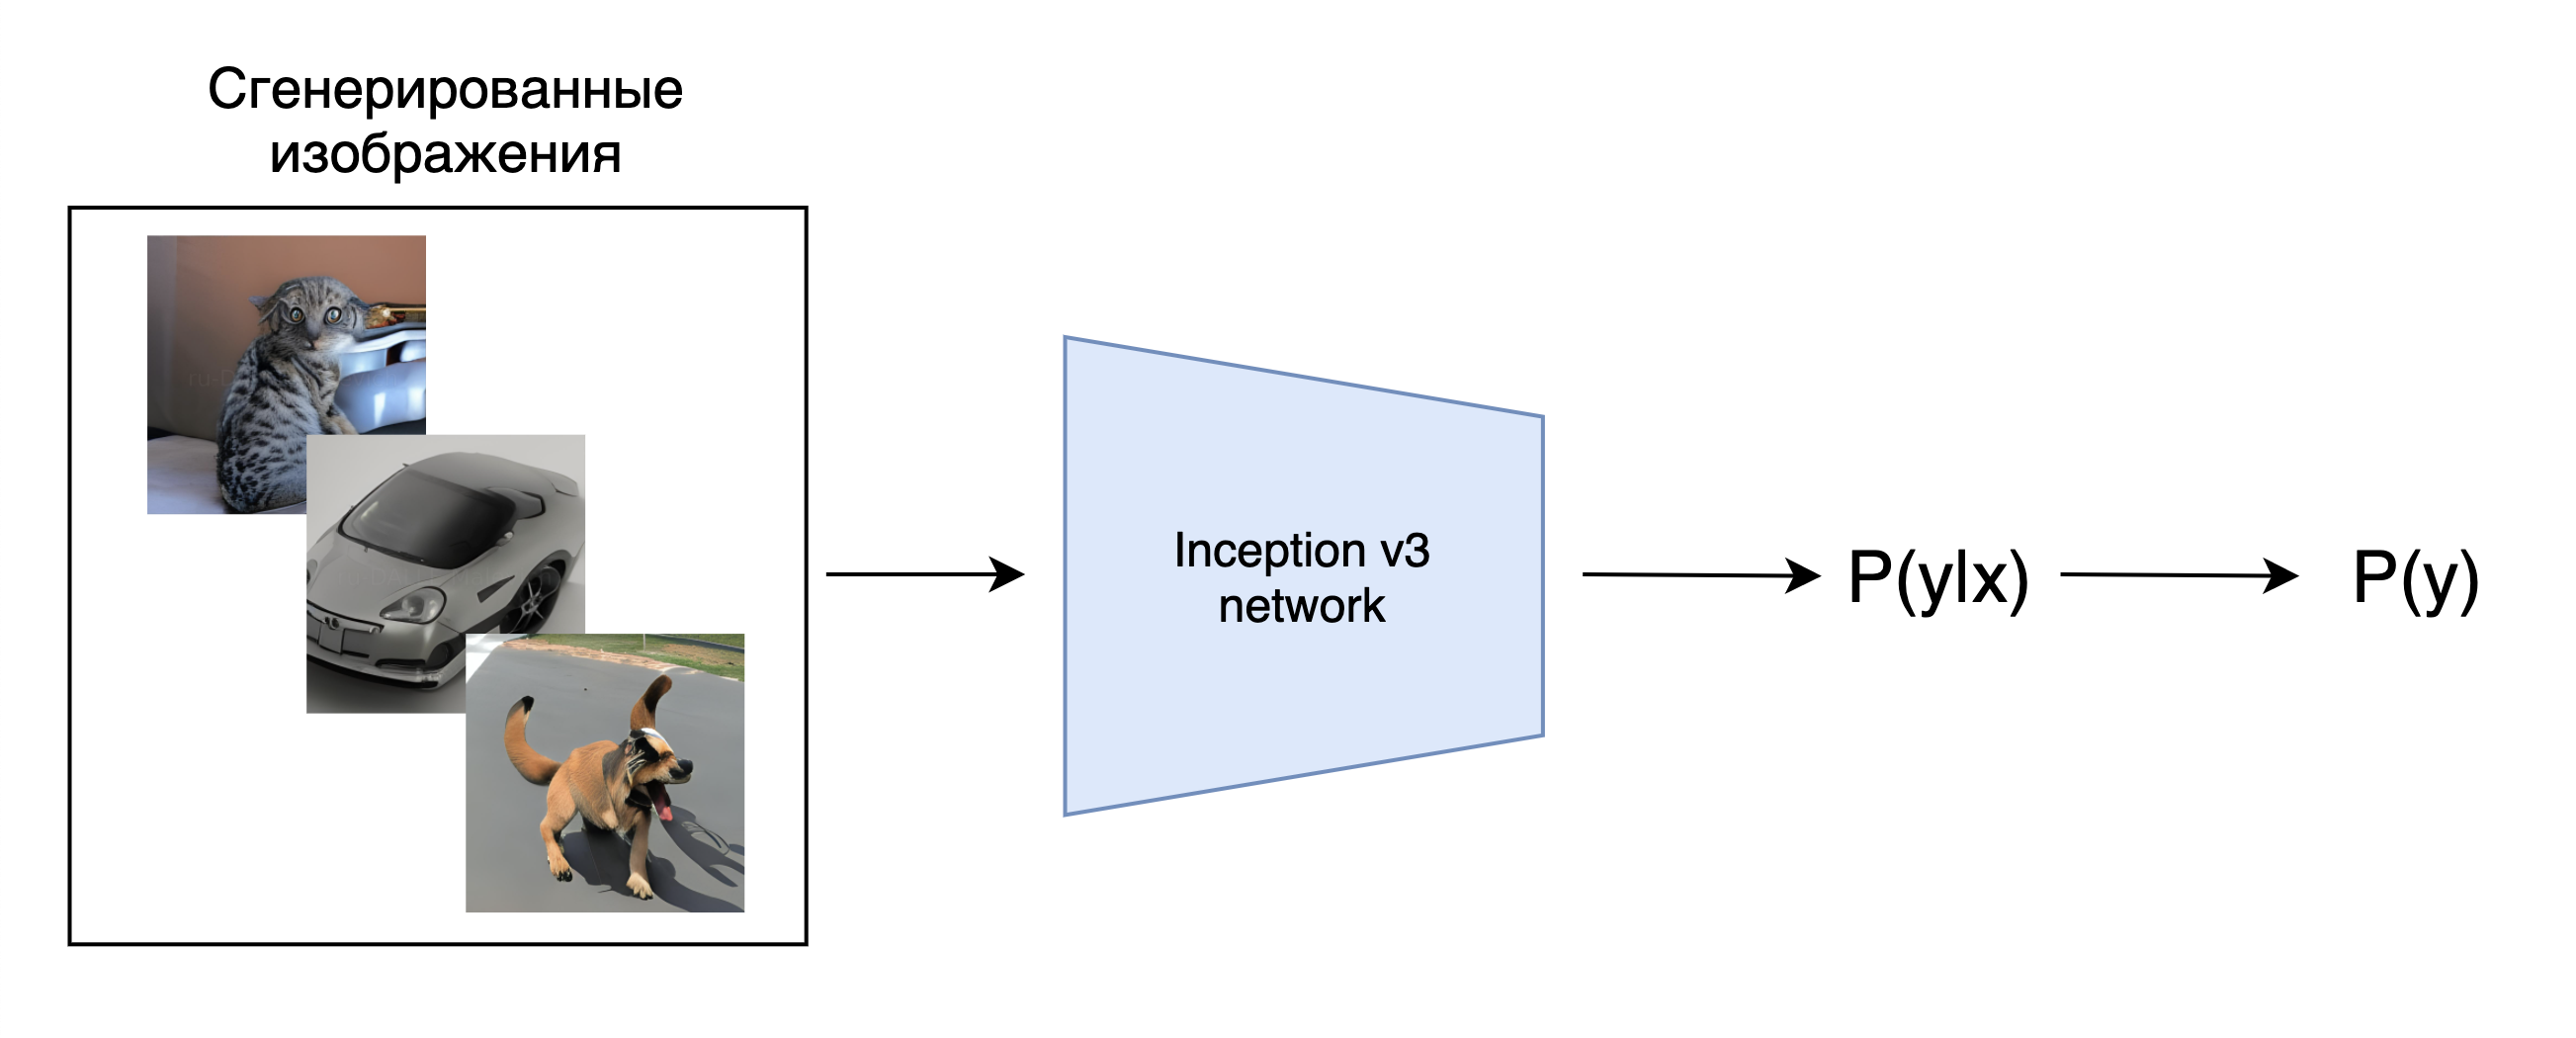

Для оценки метрики, называемой Inception score (IS), применяется классификатор Inception model, обученный на датасете ImageNet.

С помощью классификации сгенерированных изображений данной внешней моделью получается условное распределение лейблов от картинок $p(y|\mathbf{x})$. Сгенерированные картинки, похожие на что-то реальное из классов, которые есть в ImageNet, должны иметь распределение $p(y|x)$ с низкой энтропией:

\begin{equation}
    H(x) = - \sum_{i=1}^{n} p_i \log p_i
\end{equation}

То есть модель должна быть уверена, что на картинке изображена, например, собака.

Однако также сгенерированные изображения должны быть разнообразны, то есть наша модель генерации должна генерировать и кошек, и собак, и машины, а не только один какой-то понравившийся ей класс. Поэтому энтропия маргинализованного по пространству картинок распределения должна быть высокой.

\begin{equation}
    p(y) = \int_X p(y|x) dx
\end{equation}

Комбинируя эти два требования, получается метрика, которая меряет расстояние между двумя распределениями. Чем это расстояние больше, тем лучше. Метрика IS дается выражением:

\begin{equation}
    IS = exp \left( \mathbb{E}_{x \sim p_g} D_{KL}(p(y|x) \parallel p(y)) \right)
\end{equation}

где $D_{KL}$ - KL-дивергенция. $p_g$ - распределение сгенерированных изображений.

FID

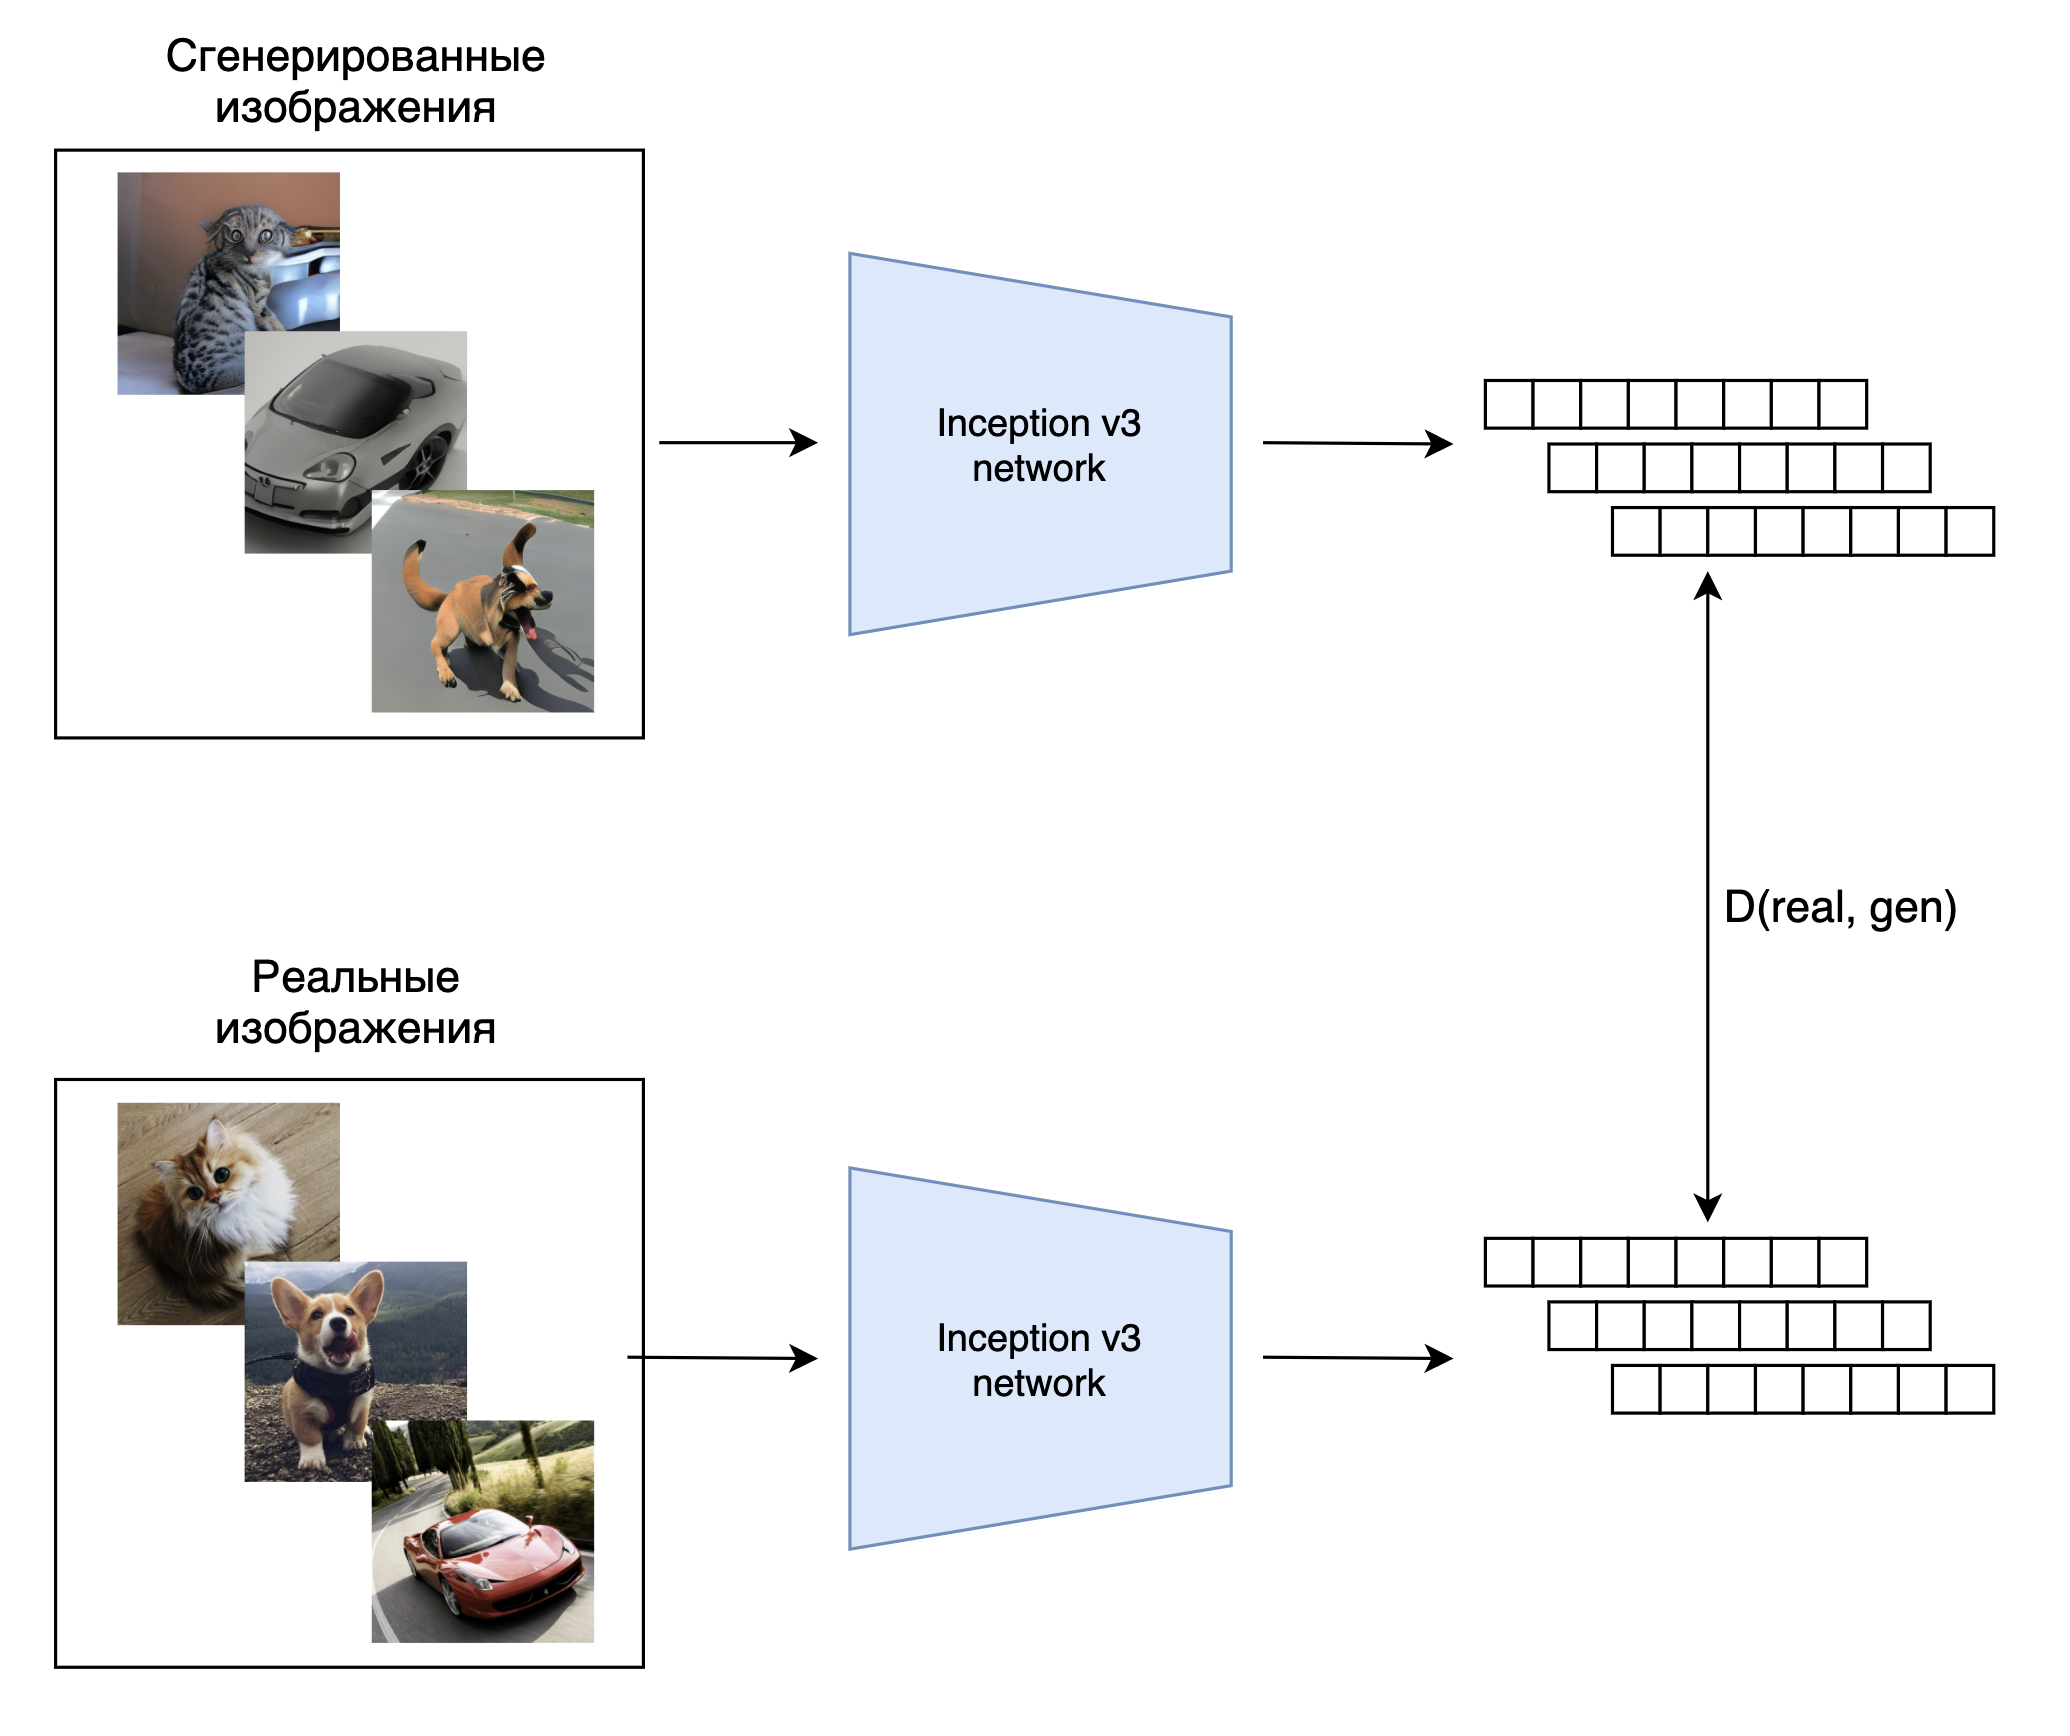

Минусом метрики IS является то, что она никак не учитывает распределение реальных данных для оценки качества сгенерированных изображений. Поэтому была предложена другая метрика Fréchet inception distance (FID).

Мотивация этой метрики состоит в том, чтобы сравнить распределения реальных и сгенерированных данных, или, другими словами, померить расстояние между двумя распределениями. Но измерения производятся не на самом распределении данных, а на некотором извлеченном из картинок представлении. Для этого каждое из сгенерированных изображений подается в модель Inception model (аналогично Inception Score), последний слой пуллинга (последний слой перед линейным преобразованием в логиты классификатора) которой выступает в качестве представления изображений. Inception v3 network, используемая для расчета обоих метрик, - это конкретная модель, поэтому можно сказать, что представление изображений в ней - это вектор длиной 2048. Представление получается также и для изображений исходного датасета.


Распределения двух полученных представлений упрощенно рассматриваются как многомерные Гауссианы, расстояние между которыми можно померить с помощью Fréchet distance.

Для одномерного нормального распределения расстояние будет выглядеть следующим образом:

\begin{equation}
    d(X, Y) = (\mu_X - \mu_Y)^2 + (\sigma_X - \sigma_Y)^2 = (\mu_X - \mu_Y)^2 + (\sigma^2_X + \sigma^2_Y - 2\sigma_X \sigma_Y)
\end{equation}

Для многомерного нормального распределения формула расстояния следующая:

\begin{equation}
    d(X, Y) = \| \mathbf{\mu}_X - \mathbf{\mu}_Y \|^2 + Tr(\mathbf{\Sigma}_X + \mathbf{\Sigma}_Y - 2\sqrt{\mathbf{\Sigma}_X \mathbf{\Sigma}_Y})
\end{equation}

Соответственно, FID показывает расстояние между сгенерированными изображениями и исходным реальным датасетом, поэтому, чем меньше расстояние, тем сгенерированные изображения лучше.

### Задание:

В данном задании нужно будет

* Обучить GAN и диффузию (DDPM) на датасете CIFAR10. Для GAN вы можете использовать методы регуляризации, чтобы улучшить его качество, например label smoothing, spectral normalization, подача шума на дискриминатор поверх сгенерированных и реальных данных (вспомогательный код для трюков в ганах приведен в ноутбуке). Переиспользуйте код из 1 и 2 домашней работы.

* Замерить качество генерации изображений с помощью метрик IS и FID. Привести примеры генерации и таблицу с результатами обучения моделей. Сравните метрики сгенерированных изображений с метриками исходного датасета.

Пример таблицы:



Model | IS $⇑$ | FID $⇓$ |
---------|------|-----------|
GAN | |
Diffusion | |
CIFAR10 | 10.98 ± 0.22 | 3.1508


### Define parameters & Load Dataset

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST, CIFAR10
from IPython.display import Image
from torchvision.utils import save_image
import os
%matplotlib inline
plt.style.use("ggplot")

class CFG:
    batch_size = 128
    num_epochs = 10
    workers = 4
    seed = 2021
    image_size = 64
    download = True
    dataroot = "data"
    nc = 3  ## number of chanels
    ngf = 64  # Size of feature maps in generator
    nz = 100  # latent random input vector
    ndf = 64  # Size of feature maps in discriminator
    lr = 0.0002
    device = "cuda" if torch.cuda.is_available() else "cpu"
    sample_dir = "./images/"


if not os.path.exists(CFG.sample_dir):
    os.makedirs(CFG.sample_dir)

cifar_dataset = CIFAR10(
    root=CFG.dataroot,
    download=CFG.download,
    transform=transforms.Compose(
        [
            transforms.Resize([CFG.image_size, CFG.image_size]),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
)

Label:  6


(array([ 140.,  578., 1378., 1406., 1163., 1691., 1246., 1402., 1351.,
         602.,  440.,  344.,  279.,  185.,   83.]),
 array([-0.99215686, -0.86091506, -0.72967321, -0.59843135, -0.46718955,
        -0.33594775, -0.20470589, -0.07346404,  0.05777776,  0.18901956,
         0.32026136,  0.45150328,  0.58274508,  0.71398687,  0.84522879,
         0.97647059]),
 <BarContainer object of 15 artists>)

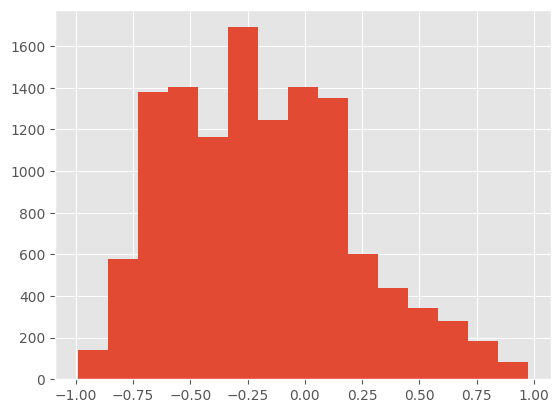

In [ ]:
img, label = cifar_dataset[0]
print("Label: ", label)
plt.hist(img[:, :, :].flatten(), bins=15)

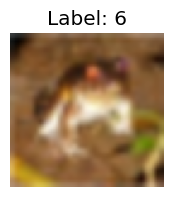

In [ ]:
# denormalization image from range (-1)-1 to range 0-1 to display it
def denorm(x):
    return (x + 1.0) / 2.0

# show image sample with matplotlib
plt.figure(figsize=(2,2))
plt.title(f"Label: {label}")
plt.imshow(np.transpose(denorm(img).cpu().numpy(), (1, 2, 0)))
plt.axis("off")
plt.show()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


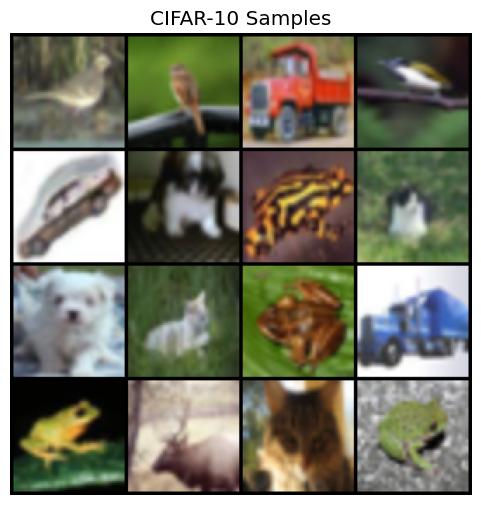

In [ ]:
# define the dataloader
from torch.utils.data import DataLoader

dataloader = DataLoader(
    cifar_dataset,
    batch_size=CFG.batch_size,
    shuffle=True,
    num_workers=CFG.workers,
)

# get a batch of images
real_images, real_labels = next(iter(dataloader))

plt.figure(figsize=(6, 6))
plt.axis("off")
plt.title("CIFAR-10 Samples")

# make grid, denormalize before plotting
grid = torchvision.utils.make_grid(denorm(real_images[:16]), nrow=4)
plt.imshow(np.transpose(grid.cpu().numpy(), (1, 2, 0)))
plt.show()

# Спектральная нормализация

In [ ]:
import torch
from torch.optim.optimizer import Optimizer, required

from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn
from torch import Tensor
from torch.nn import Parameter

def l2normalize(v, eps=1e-12):
    return v / (v.norm() + eps)


class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v.data = l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
            u.data = l2normalize(torch.mv(w.view(height,-1).data, v.data))

        # sigma = torch.dot(u.data, torch.mv(w.view(height,-1).data, v.data))
        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False


    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = l2normalize(u.data)
        v.data = l2normalize(v.data)
        w_bar = Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)


    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)

## Tricks
- use deeper CNN
- use LeakyRELU instead of ReLU
- use BatchNorm, Dropout
- SpectralNorm

In [ ]:
import torch.nn as nn

# Generator
class Generator(nn.Module):
    def __init__(self, nc, nz, ngf):
        super(Generator, self).__init__()

        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            # (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            # (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            # (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            # (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),

            # output (nc) x 64 x 64
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)


# Discriminator
class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            # input nc x 64 x 64
            SpectralNorm(nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),

            SpectralNorm(nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),

            SpectralNorm(nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),

            SpectralNorm(nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),

            # output 1 x 1 x 1
            SpectralNorm(nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False)),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

In [ ]:
# create new Generator model
G = Generator(CFG.nc, CFG.nz, CFG.ngf).to(CFG.device)

# create new Discriminator model
D = Discriminator(CFG.nc, CFG.ndf).to(CFG.device)

Output fake images shape: torch.Size([2, 3, 64, 64])


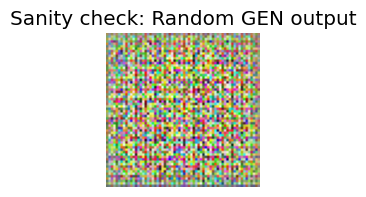

In [ ]:
# show the output of model
z = torch.randn(2, CFG.nz, 1, 1).to(CFG.device)
y = G(z)

print("Output fake images shape:", y.shape)

fake_img = denorm(y[0].detach().cpu())
plt.figure(figsize=(2,2))
plt.imshow(np.transpose(fake_img.numpy(), (1,2,0)))
plt.axis("off")
plt.title("Sanity check: Random GEN output")
plt.show()

In [ ]:
# define the criterion is nn.BCELoss()
criterion = nn.BCELoss()
## Define the optimizer for generator and discrimator
d_optimizer = torch.optim.Adam(D.parameters(), lr=CFG.lr, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=CFG.lr, betas=(0.5, 0.999))

G = G.to(CFG.device)
D = D.to(CFG.device)

print(f"Using device: {CFG.device}")

Using device: cuda


Discriminator Training

In [ ]:
# Label Smoothing, i.e. if you have two target labels: Real=1 and Fake=0, then for each incoming sample,
#  if it is real, then replace the label with a random number between 0.7 and 1.2, and
#  if it is a fake sample, replace it with 0.0 and 0.3 (for example).
#make the labels the noisy for the discriminator: occasionally flip the labels when training the discriminator

In [ ]:
latent_size = CFG.nz
device = CFG.device
batch_size = CFG.batch_size

def reset_grad():
    ## reset gradient for optimizer of generator and discrimator
    D.zero_grad()
    G.zero_grad()


def train_discriminator(images):
    # текущий реальный размер батча (последний может быть < CFG.batch_size)
    curr_batch_size = images.size(0)

    # Create the labels which are later used as input for the BCE loss
    # Real labels sampled from interval [0.7, 1.0]
    real_labels = torch.empty(curr_batch_size, device=device).uniform_(0.7, 1.0)

    # Fake labels sampled from interval [0.0, 0.3]
    fake_labels = torch.empty(curr_batch_size, device=device).uniform_(0.0, 0.3)

    # Randomly flip labels (with small probability)
    flip_idx = torch.rand(curr_batch_size, device=device) < 0.05  # 5% flip
    real_labels[flip_idx] = 0.0
    fake_labels[flip_idx] = 1.0

    # Loss for real images
    outputs = D(images)  # [curr_batch_size]
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(curr_batch_size, latent_size, 1, 1, device=device)
    fake_images = G(z)
    outputs = D(fake_images.detach())  # [curr_batch_size]
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Sum losses
    d_loss = d_loss_real + d_loss_fake

    # Reset gradients
    reset_grad()

    # Compute gradients
    d_loss.backward()

    # Adjust the parameters using backprop
    d_optimizer.step()

    return d_loss, real_score, fake_score

Generator Training

In [ ]:
#Add gauss noise
#noise = 0.005*np.random.uniform()*np.amax(sound)
latent_size=CFG.nz
device = CFG.device

def train_generator():
    # Generate fake images and calculate loss
    # z = torch.randn(batch_size, latent_size).to(device)
    z = np.random.normal(0, 1, (batch_size, latent_size, 1, 1))
    noise = 0.005 * np.random.uniform() * np.amax(z)
    z = z.astype('float64') + noise * np.random.normal(size=z.shape)
    z = torch.Tensor(z).to(device)

    fake_images = G(z)
    labels = torch.ones(batch_size, device=device)  # [batch_size]

    # calculate the generator loss
    g_loss = criterion(D(fake_images), labels)

    # Reset gradients
    reset_grad()

    # Backprop and optimize
    g_loss.backward()
    g_optimizer.step()

    return g_loss, fake_images

## Start the training process

In [ ]:
def save_fake_images(index, num_images=64):
    z = torch.randn(num_images, latent_size, 1, 1, device=device)
    fake_images = G(z)
    fake_images = denorm(fake_images)

    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(fake_images, os.path.join(CFG.sample_dir, fake_fname), nrow=8)

In [ ]:
%%time
device = CFG.device
num_epochs = CFG.num_epochs
batch_size = CFG.batch_size

total_step = len(dataloader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

G.to(device)
D.to(device)

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(dataloader):
        if images.size(0) != batch_size:
            continue

        # Load a batch & transform to vectors
        images = images.to(device)  # [batch, 3, 64, 64]

        # Train the discriminator
        d_loss, real_score, fake_score = train_discriminator(images)

        # Train the generator
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print(
                'Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                .format(
                    epoch + 1, num_epochs, i + 1, total_step,
                    d_loss.item(), g_loss.item(),
                    real_score.mean().item(), fake_score.mean().item()
                )
            )

    # Sample and save images
    save_fake_images(epoch+1)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [1/10], Step [200/391], d_loss: 1.7188, g_loss: 2.8638, D(x): 0.89, D(G(z)): 0.71
Saving fake_images-0001.png
Epoch [2/10], Step [200/391], d_loss: 1.0989, g_loss: 1.6157, D(x): 0.61, D(G(z)): 0.30
Saving fake_images-0002.png
Epoch [3/10], Step [200/391], d_loss: 1.2497, g_loss: 2.3249, D(x): 0.83, D(G(z)): 0.51
Saving fake_images-0003.png
Epoch [4/10], Step [200/391], d_loss: 1.1445, g_loss: 1.4471, D(x): 0.64, D(G(z)): 0.34
Saving fake_images-0004.png
Epoch [5/10], Step [200/391], d_loss: 1.1299, g_loss: 1.6260, D(x): 0.69, D(G(z)): 0.28
Saving fake_images-0005.png
Epoch [6/10], Step [200/391], d_loss: 1.1786, g_loss: 1.4867, D(x): 0.47, D(G(z)): 0.08
Saving fake_images-0006.png
Epoch [7/10], Step [200/391], d_loss: 1.2389, g_loss: 1.9499, D(x): 0.86, D(G(z)): 0.54
Saving fake_images-0007.png
Epoch [8/10], Step [200/391], d_loss: 1.0213, g_loss: 1.3666, D(x): 0.71, D(G(z)): 0.21
Saving fake_images-0008.png
Epoch [9/10], Step [200/391], d_loss: 1.0619, g_loss: 1.7543, D(x): 0.77

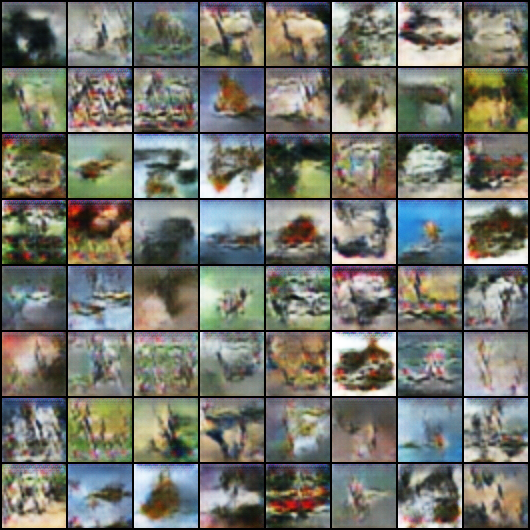

In [ ]:
Image(os.path.join(CFG.sample_dir, 'fake_images-0010.png'))

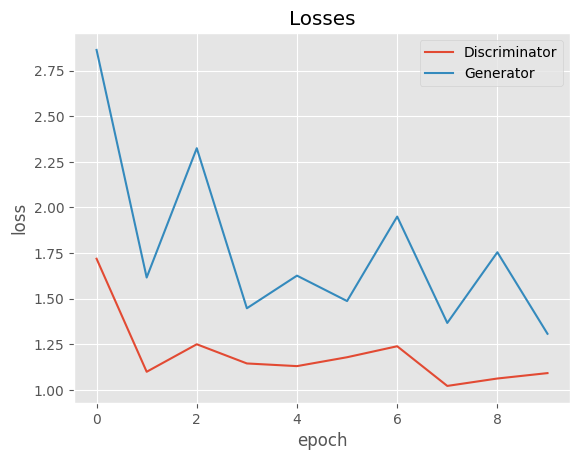

In [ ]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

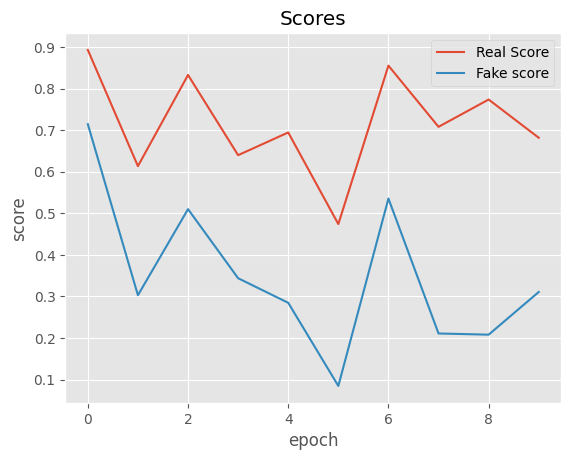

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

## DDPM
Код из 1 лабы

In [ ]:
from typing import List, Tuple, Optional

import torch
import torch.nn.functional as F
import torch.utils.data
from torch import nn
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# Load file unet.py to the filesystem of colab
from unet import UNet

In [ ]:
def gather(consts: torch.Tensor, t: torch.Tensor):
    """Gather consts for t and reshape to feature map shape"""
    c = consts.gather(-1, t)
    return c.reshape(-1, 1, 1, 1)

In [ ]:
class DenoiseDiffusion:
    """
    ## Denoise Diffusion
    """

    def __init__(self, eps_model: nn.Module, n_steps: int, device: torch.device):
        """
        * eps_model - epsilon_theta(x_t, t) model
        * n_steps - t
        * device - the device to place constants on
        """
        super().__init__()
        self.eps_model = eps_model

        # Create beta_1 ... beta_T linearly increasing variance schedule
        self.beta = torch.linspace(0.0001, 0.02, n_steps).to(device)

        # alpha_t = 1 - beta_t
        self.alpha = 1 - self.beta
        # [1]
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        # T
        self.n_steps = n_steps
        # sigma^2 = beta
        self.sigma2 = self.beta

    def q_xt_x0(self, x0: torch.Tensor, t: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Get q(x_t|x_0) distribution

        [2]
        """
        # [3]
        mean = gather(self.alpha_bar, t) ** 0.5 * x0
        # [4]
        var = 1 - gather(self.alpha_bar, t)
        return mean, var

    def q_sample(self, x0: torch.Tensor, t: torch.Tensor, eps: Optional[torch.Tensor] = None):
        """
        Sample from q(x_t|x_0)

        [5]
        """

        # [6]
        if eps is None:
            eps = torch.randn_like(x0)

        # get q(x_t|x_0)
        mean, var = self.q_xt_x0(x0, t)
        # Sample from q(x_t|x_0)
        return mean + (var ** 0.5) * eps

    def p_sample(self, xt: torch.Tensor, t: torch.Tensor):
        """
        Sample from p_theta(x_{t-1}|x_t)

        [7]
        """

        # epsilon_theta(x_t, t)
        eps_theta = self.eps_model(xt, t)
        # [8]
        alpha_bar = gather(self.alpha_bar, t)
        # alpha_t
        alpha = gather(self.alpha, t)
        # [9]
        beta_t = gather(self.beta, t)
        eps_coef = beta_t / ((1 - alpha_bar)).sqrt()
        # [10]
        mean = (1.0 / alpha.sqrt()) * (xt - eps_coef * eps_theta)
        # sigma^2
        var = gather(self.sigma2, t)

        # [11]
        eps = torch.randn_like(xt)
        # Sample
        return mean + (var ** .5) * eps

    def loss(self, x0: torch.Tensor, noise: Optional[torch.Tensor] = None):
        """
        Simplified Loss

        [12]
        """
        # Get batch size
        batch_size = x0.shape[0]
        # Get random t for each sample in the batch
        t = torch.randint(0, self.n_steps, (batch_size,), device=x0.device)

        # [13]
        if noise is None:
            noise = torch.randn_like(x0)

        # Sample x_t for q(x_t|x_0)
        xt = self.q_sample(x0, t, eps=noise)
        # [14]
        eps_theta = self.eps_model(xt, t)

        # MSE loss
        return F.mse_loss(eps_theta, noise)

In [ ]:
class CIFARDataset(torchvision.datasets.CIFAR10):
    def __init__(self, image_size: int):
        transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize(image_size),
            torchvision.transforms.ToTensor(),
        ])

        super().__init__("data", train=True, download=True, transform=transform)

    def __getitem__(self, item):
        # нам нужны только картинки, без меток
        return super().__getitem__(item)[0]


def plot_samples(tensor: torch.Tensor):
    """
    tensor: [N, C, H, W], C = 1 или 3
    """
    x = tensor.detach().cpu()
    x = x.clamp(0.0, 1.0)

    grid = torchvision.utils.make_grid(x, nrow=4)
    npimg = grid.numpy()
    plt.figure(figsize=(6, 6))
    plt.axis("off")
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


class Configs:
    device: torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # U-Net model for epsilon_theta(x_t, t)
    eps_model: UNet
    # DDPM algorithm
    diffusion: DenoiseDiffusion

    # Number of channels in the image. 3 for RGB.
    image_channels: int = 3
    # Image size (CIFAR10: 32x32)
    image_size: int = 32
    # Number of channels in the initial feature map
    n_channels: int = 64
    # The list of channel numbers at each resolution.
    # The number of channels is `channel_multipliers[i] * n_channels`
    channel_multipliers: List[int] = [1, 2, 2, 4]
    # The list of booleans that indicate whether to use attention at each resolution
    is_attention: List[int] = [False, False, False, True]

    # Number of time steps T
    n_steps: int = 1_000
    # Batch size
    batch_size: int = 128
    # Number of samples to generate
    n_samples: int = 16
    # Learning rate
    learning_rate: float = 2e-5

    # Number of training epochs
    epochs: int = 10

    # Dataset
    dataset: torch.utils.data.Dataset = CIFARDataset(image_size)
    # Dataloader
    data_loader: torch.utils.data.DataLoader

    # Adam optimizer
    optimizer: torch.optim.Adam

    def init(self):
        # Create epsilon_theta(x_t, t) model
        self.eps_model = UNet(
            image_channels=self.image_channels,
            n_channels=self.n_channels,
            ch_mults=self.channel_multipliers,
            is_attn=self.is_attention,
        ).to(self.device)

        # Create DDPM class
        self.diffusion = DenoiseDiffusion(
            eps_model=self.eps_model,
            n_steps=self.n_steps,
            device=self.device,
        )

        # Create dataloader
        self.data_loader = torch.utils.data.DataLoader(
            self.dataset,
            self.batch_size,
            shuffle=True,
            pin_memory=True
        )

        # Create optimizer
        self.optimizer = torch.optim.Adam(self.eps_model.parameters(), lr=self.learning_rate)

    def sample(self):
        with torch.no_grad():
            # [1] start from pure noise
            x = torch.randn(self.n_samples, self.image_channels, self.image_size, self.image_size).to(self.device)

            # Remove noise for T steps
            progress_bar = tqdm(range(self.n_steps))
            for t_ in progress_bar:
                progress_bar.set_description(f"Sampling")
                # t
                t = self.n_steps - t_ - 1
                # [2]
                x = self.diffusion.p_sample(x, x.new_full((self.n_samples,), t, dtype=torch.long))

            # Log samples
            plot_samples(x.detach().cpu())

    def train(self, epoch):
        # Iterate through the dataset
        progress_bar = tqdm(self.data_loader)
        for data in progress_bar:
            progress_bar.set_description(f"Epoch {epoch + 1}")

            # Move data to device
            data = data.to(self.device)

            # Make the gradients zero
            self.optimizer.zero_grad()

            # Calculate loss
            loss = self.diffusion.loss(data)
            # Compute gradients
            loss.backward()

            # Take an optimization step
            self.optimizer.step()

            # Track the loss
            progress_bar.set_postfix(loss=loss.detach().cpu().item())

    def run(self):
        for epoch in range(self.epochs):
            # Train the model
            self.train(epoch)
            # Sample some images
            self.sample()

Sampling: 100%|██████████| 1000/1000 [00:56<00:00, 17.55it/s]


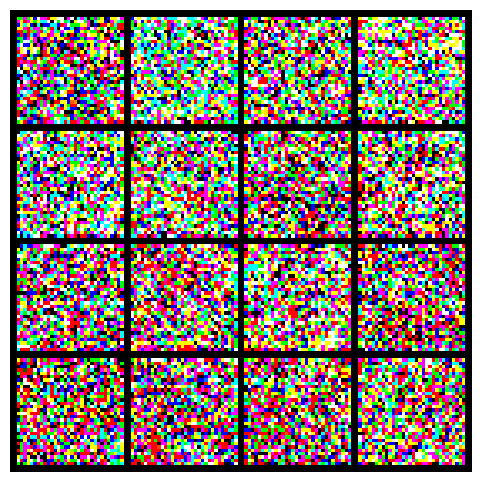

Sampling: 100%|██████████| 1000/1000 [00:56<00:00, 17.58it/s]


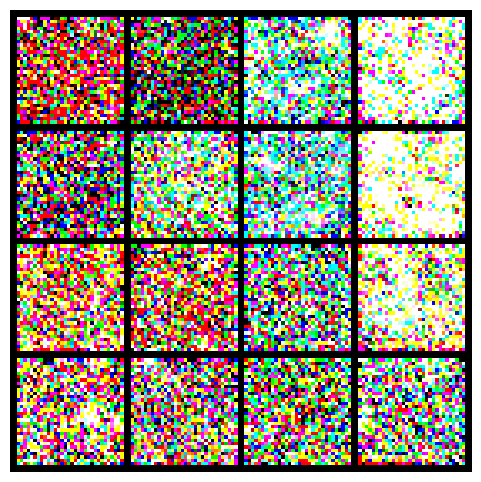

Sampling: 100%|██████████| 1000/1000 [00:56<00:00, 17.58it/s]


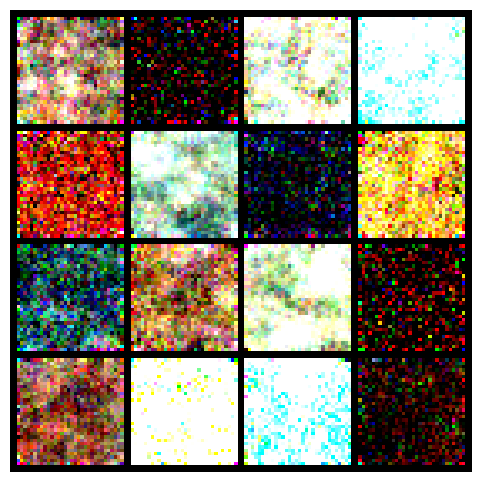

Sampling: 100%|██████████| 1000/1000 [00:57<00:00, 17.50it/s]


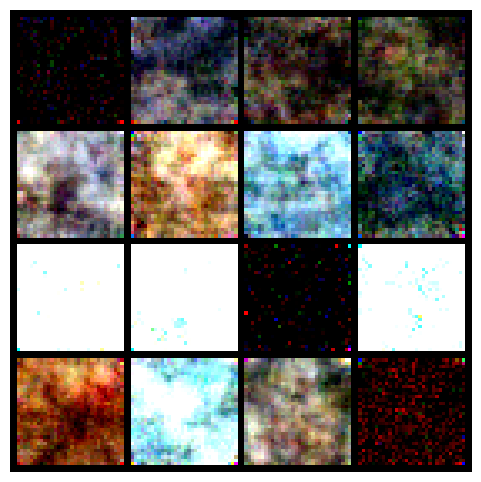

Sampling: 100%|██████████| 1000/1000 [00:56<00:00, 17.58it/s]


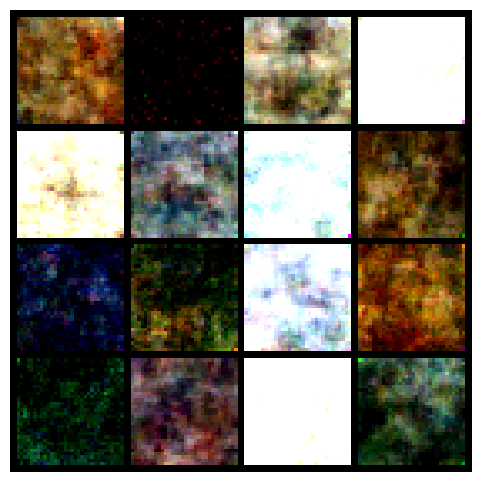

Sampling: 100%|██████████| 1000/1000 [00:56<00:00, 17.58it/s]


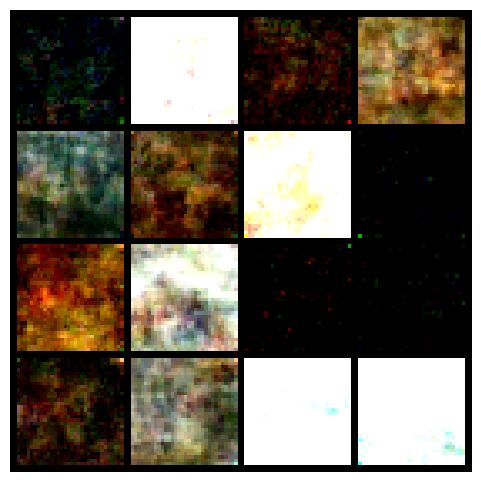

Sampling: 100%|██████████| 1000/1000 [00:56<00:00, 17.61it/s]


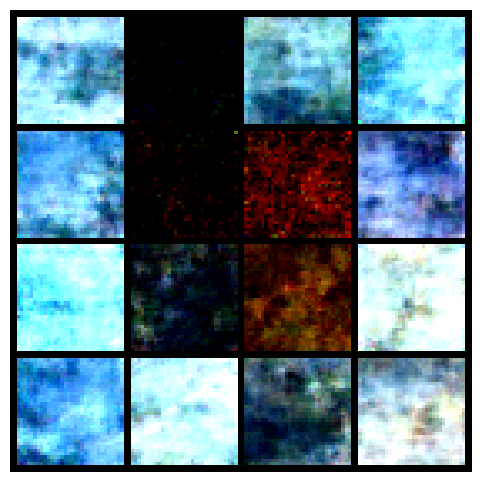

Sampling: 100%|██████████| 1000/1000 [00:56<00:00, 17.59it/s]


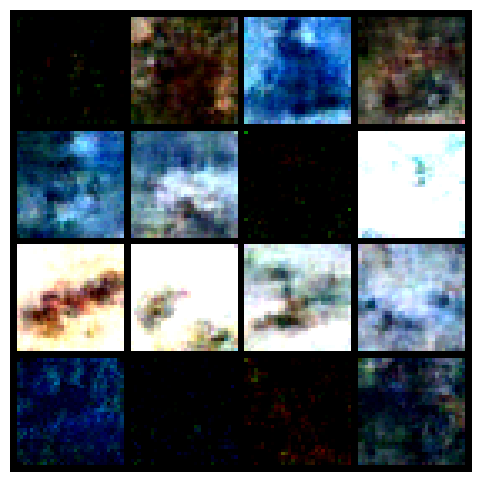

Sampling: 100%|██████████| 1000/1000 [00:56<00:00, 17.59it/s]


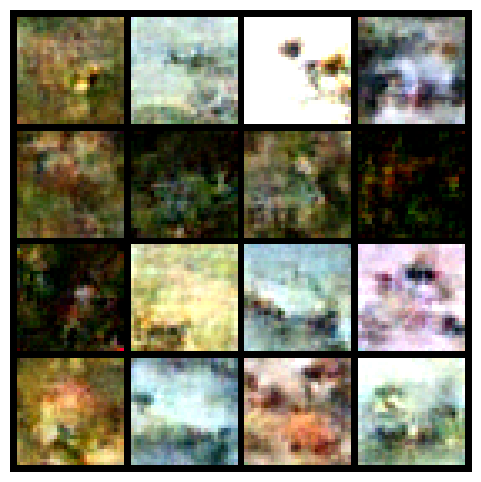

Sampling: 100%|██████████| 1000/1000 [00:57<00:00, 17.49it/s]


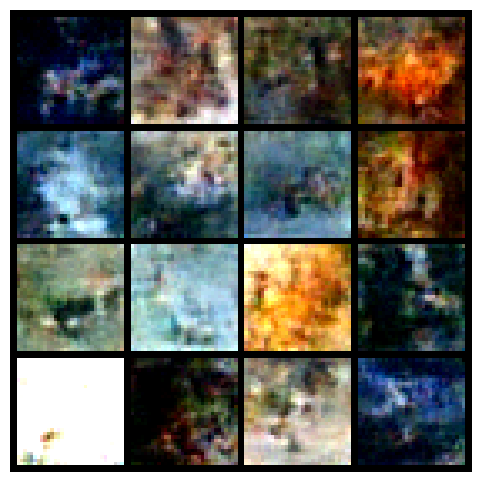

CPU times: user 42min 59s, sys: 11min 5s, total: 54min 5s
Wall time: 54min 45s


In [ ]:
%%time
# Create configurations
configs = Configs()

# Initialize
configs.init()

# Start and run the training loop
configs.run()

### install library from https://github.com/w86763777/pytorch-gan-metrics.git
Currently, this package supports following metrics:
- Inception Score (IS)
- Fréchet Inception Distance (FID)

In [ ]:
# clone is repo: https://github.com/w86763777/pytorch-gan-metrics.git and install pytorch-gan-metrics
!git clone https://github.com/w86763777/pytorch-gan-metrics.git
!pip install pytorch-gan-metrics

Cloning into 'pytorch-gan-metrics'...
remote: Enumerating objects: 342, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 342 (delta 55), reused 96 (delta 46), pack-reused 230 (from 1)
Receiving objects: 100% (342/342), 93.34 KiB | 7.18 MiB/s, done.
Resolving deltas: 100% (188/188), done.


In [ ]:
%cd ..
#### Prepare Statistics for FID


/content


In [ ]:
real_images = []
for batch, _ in dataloader:
    real_images.append(batch)
real_images = torch.cat(real_images, dim=0)[:5000]  # 5k для FID достаточно
real_images = real_images.to(device)
print("Real dataset for metrics:", real_images.shape)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Real dataset for metrics: torch.Size([5000, 3, 64, 64])


## Метрики GAN

In [ ]:
%cd pytorch-gan-metrics
!pip install .
%cd ..

/content/pytorch-gan-metrics
Processing /content/pytorch-gan-metrics
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch_image_generation_metrics: filename=pytorch_image_generation_metrics-0.6.1-py3-none-any.whl size=21852 sha256=bb22210dc9eef8540b6b32e65e7d2d3f28274847d2c66bb7f351cdeef7734175
  Stored in directory: /root/.cache/pip/wheels/76/1b/f5/a5ab2c6606cd5887da5114cf47cf29fb8bd02dd14562479ed6
Successfully built pytorch_image_generation_metrics
  Attempting uninstall: pytorch_image_generation_metrics
    Found existing installation: pytorch-image-generation-metrics 0.6.1
    Uninstalling pytorch-image-generation-metrics-0.6.1:
      Successfully uninstalled pytorch-image-generation-metrics-0.6.1
/content


In [ ]:
!wget https://www.cs.cmu.edu/~clean-fid/stats/cifar10_legacy_pytorch_train_32.npz -O cifar10_stats.npz

--2025-11-30 12:53:39--  https://www.cs.cmu.edu/~clean-fid/stats/cifar10_legacy_pytorch_train_32.npz
Resolving www.cs.cmu.edu (www.cs.cmu.edu)... 128.2.42.95
Connecting to www.cs.cmu.edu (www.cs.cmu.edu)|128.2.42.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32149756 (31M)
Saving to: ‘cifar10_stats.npz’

cifar10_stats.npz   100%[===================>]  30.66M  1.96MB/s    in 16s     

2025-11-30 12:53:56 (1.92 MB/s) - ‘cifar10_stats.npz’ saved [32149756/32149756]



In [ ]:
 # import function from pytorch_gan_metrics
from pytorch_image_generation_metrics import (get_inception_score,
                                 get_fid,
                                 get_inception_score_and_fid)
from torch.utils.data import Dataset, DataLoader

# create the Generator Dataset. returns the image, generated from the Generator network
class GeneratorDataset(Dataset):
    def __init__(self, G, z_dim, size=5000):
        self.G = G
        self.z_dim = z_dim
        self.size = size

    def __len__(self):
        return self.size

    def __getitem__(self, index):
        z = torch.randn(1, self.z_dim, 1, 1).to(device)
        with torch.no_grad():
            img = G(z)[0]
        return img

gan_set = GeneratorDataset(G, CFG.nz, size=5000)
gan_loader = DataLoader(gan_set, batch_size=64, shuffle=False)

# Inception Score
is_mean, is_std = get_inception_score(gan_loader, device=device)
print(f"GAN Inception Score: {is_mean:.4f} ± {is_std:.4f}")

# Frechet Inception Distance
fid = get_fid(gan_loader, "cifar10_stats.npz", device=device)
print(f"GAN FID: {fid:.4f}")


GAN Inception Score: 1.9693 ± 0.0248
GAN FID: 231.9513


In [ ]:
class FastDiffusionDataset(Dataset):
    def __init__(self, diffusion, image_channels, image_size, size=300, steps=100):
        self.diffusion = diffusion
        self.image_channels = image_channels
        self.image_size = image_size
        self.size = size
        self.steps = steps # сколько шагов реально делать

    def __len__(self):
        return self.size

    def __getitem__(self, index):
        with torch.no_grad():
            x = torch.randn(1, self.image_channels, self.image_size, self.image_size).to(device)
            T = self.diffusion.n_steps
            step = max(T // self.steps, 1)

            for i in range(self.steps):
                t = T - 1 - i * step
                t_batch = torch.tensor([t], device=device, dtype=torch.long)
                x = self.diffusion.p_sample(x, t_batch)

            return x[0]


diff_set = FastDiffusionDataset(configs.diffusion,
                            configs.image_channels,
                            configs.image_size,
                            size=300)
diff_loader = DataLoader(diff_set, batch_size=16, shuffle=False)

In [ ]:
# Inception Score
is_mean_d, is_std_d = get_inception_score(diff_loader, device=device)
print(f"Diffusion Inception Score: {is_mean_d:.4f} ± {is_std_d:.4f}")

# Frechet Inception Distance
fid_d = get_fid(diff_loader, "cifar10_stats.npz", device=device)
print(f"Diffusion FID: {fid_d:.4f}")

Diffusion Inception Score: 1.1823 ± 0.0265
Diffusion FID: 438.9872


| Model      | Inception Score ↑        | FID ↓        |
|------------|-------------------------|--------------|
| GAN        | 1.9693 ± 0.0248          | 231.9513     |
| Diffusion  | 1.1823 ± 0.0265          | 438.9872     |
| CIFAR-10 (real data) | 10.98 ± 0.22  | 3.1508       |

По результатам оценки генеративных моделей на датасете CIFAR-10 наблюдаем, что DCGAN показывает более высокое качество генерации по сравнению с диффузионной моделью, если опираться на метрики IS и FID. У GAN выше Inception Score (1.97 против 1.18), что означает большую уверенность классификатора в содержимом сгенерированных изображений. Также GAN достигает меньшего значения FID (232 против 439), следовательно, распределение его изображений ближе к распределению реальных данных.

Тем не менее, оба результата значительно хуже референсных значений CIFAR-10 (IS ≈ 11, FID ≈ 3), что ожидаемо — модели обучались ограниченное количество эпох и на сравнительно небольшой архитектуре.

Важно отметить, что диффузионная модель обучалась и оценивалась с уменьшенным числом шагов семплирования и на ограниченном числе примеров, что снижает качество результата. В полноценной конфигурации DDPM обычно превосходит GAN по FID.

